In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import DarkVerse as dv


In [3]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [4]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



### USING SELECTION CLASS
sub = dv.Selection(t, randoms, 0.4, 0.6, 10.5, 11.0, config)



The following patch numbers have no objects: {26}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


In [5]:


# Fit HOD with custom bounds
hod_params, pcov = sub.fit_hod(
    p0=[12.5, 13.5, 1.0],
    bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
)

results = sub.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^12.50, M_1 = 10^13.88, alpha = 0.92


## WITHOUT BOOTSTRAP

/tmp/ipykernel_1278304/47077783.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x800 with 0 Axes>

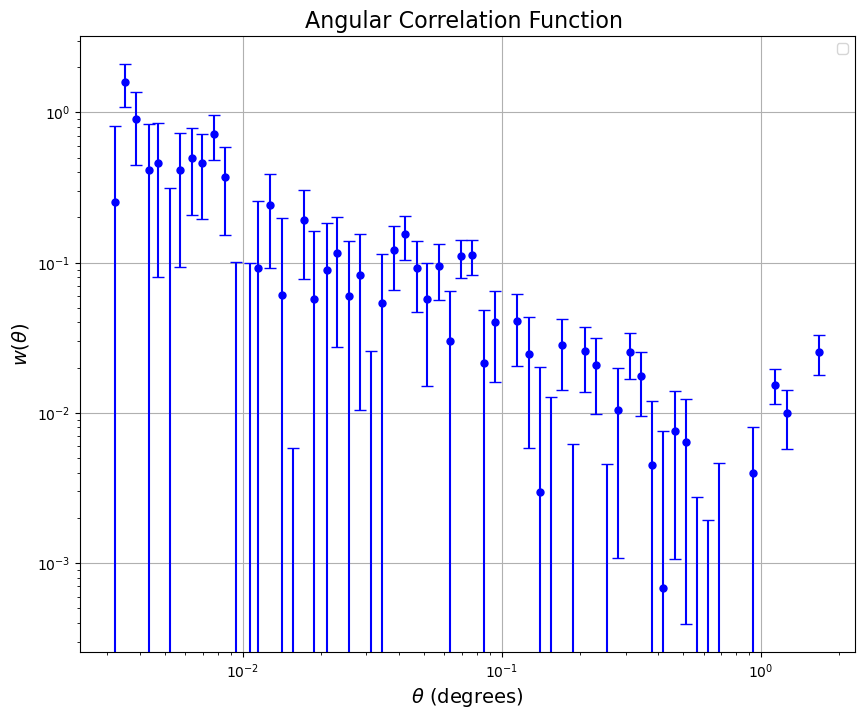

In [6]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta'] #shot noise

w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

## WITH BOOTSTRAP

/tmp/ipykernel_1278304/605324858.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x800 with 0 Axes>

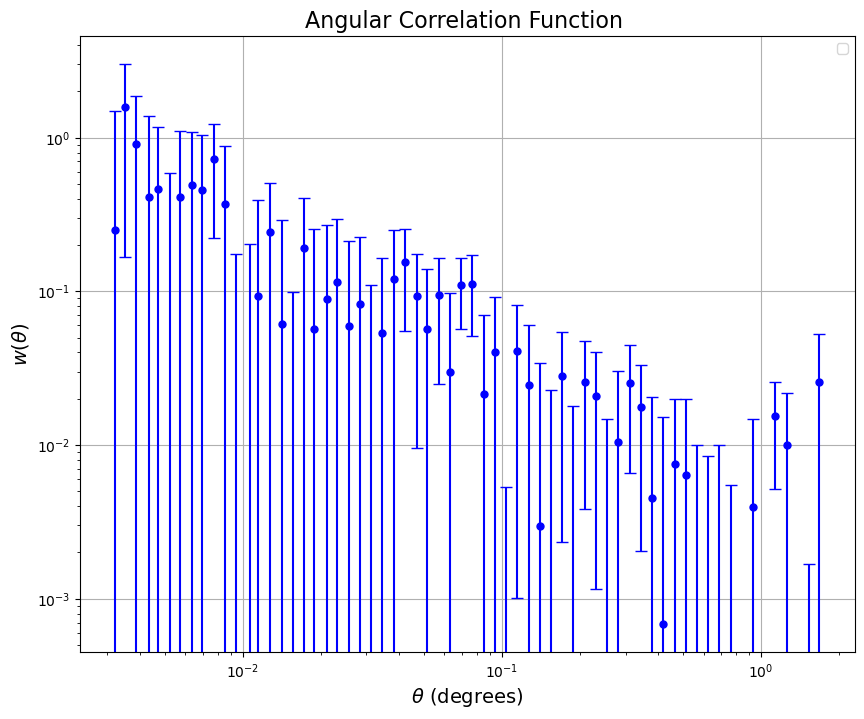

In [7]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']

w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

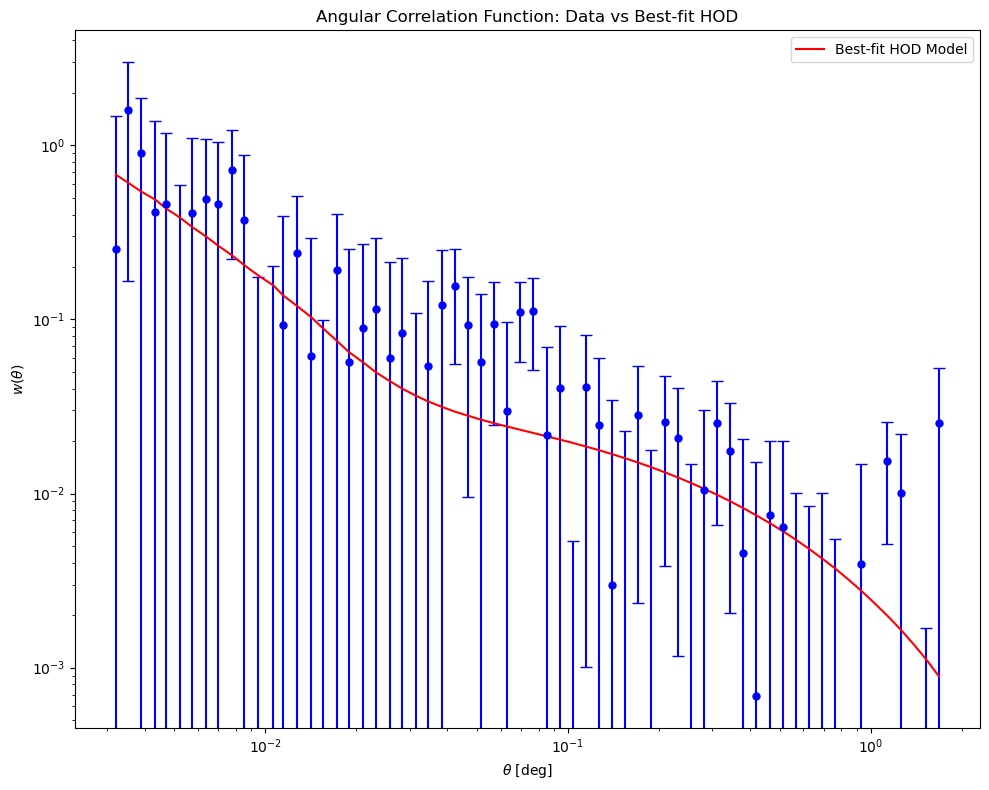

In [8]:


# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$w(\theta)$')
plt.legend()
plt.title('Angular Correlation Function: Data vs Best-fit HOD')
plt.tight_layout()
plt.show()


In [9]:
bias_eff = sub.gg.bias_effective_tracer
print(f"Effective galaxy bias: {bias_eff:.3f}")


Effective galaxy bias: 1.096


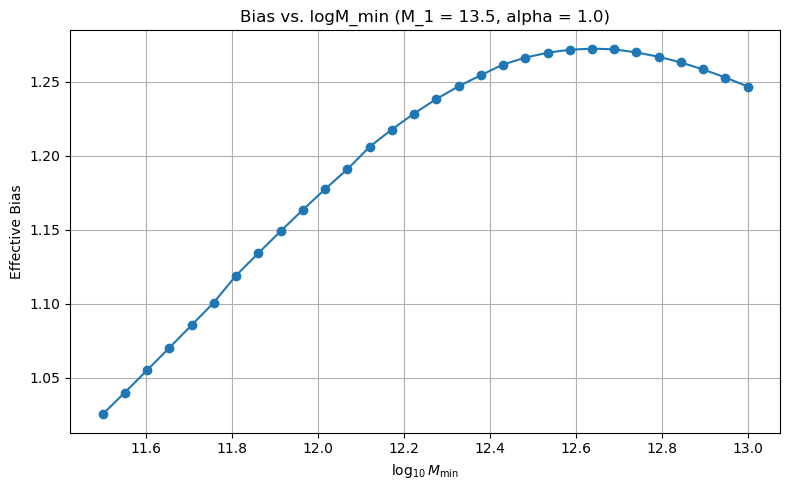

In [10]:
logM_1_fixed = 13.5
alpha_fixed = 1.0

logM_min_vals = np.linspace(11.5, 13.0, 30)
bias_vals = []

for logM_min in logM_min_vals:
    sub.hod_model(logM_min, logM_1_fixed, alpha_fixed)
    bias = sub.gg.bias_effective_tracer
    bias_vals.append(bias)

plt.figure(figsize=(8, 5))
plt.plot(logM_min_vals, bias_vals, marker='o')
plt.xlabel(r"$\log_{10} M_{\mathrm{min}}$")
plt.ylabel("Effective Bias")
plt.title("Bias vs. logM_min (M_1 = 13.5, alpha = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
mask = (theta >= 0.1) & (theta <= 0.4)

bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list= w_obs,
    w_theta_error_list=w_err,
    sum_rr_list=[results['rr_counts']],
    mask=mask
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [0.9143817113568162]
Bias errors: [0.14363378270272198]
